# LR Delivery Time Prediction — Complete Notebook

**Name:** Gurwinder Harika

**Assignment ID:** LR/02

**Instructions:** Run cells in order. This notebook contains the full pipeline: data loading, preprocessing, EDA, feature engineering, model building (Linear Regression + selection), evaluation, residual and coefficient analysis, and answers to subjective questions.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', 200)
plt.style.use('default')


In [2]:
# Load dataset (ensure porter_data_1.csv exists at /mnt/data)
DATA_PATH = "/mnt/data/porter_data_1.csv"
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Loaded rows:", len(df))
df.head()

Loaded rows: 175777


,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20


In [3]:
# Parse timestamps and create target delivery_duration_min
for col in ['created_at', 'actual_delivery_time']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

if 'created_at' in df.columns and 'actual_delivery_time' in df.columns:
    df['delivery_duration_min'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60.0
else:
    df['delivery_duration_min'] = np.nan

print('Target created, sample values:')
df[['created_at','actual_delivery_time','delivery_duration_min']].head(6)

Target created, sample values:


,created_at,actual_delivery_time,delivery_duration_min
0,2015-02-06 22:24:17,2015-02-06 23:11:17,47.0
1,2015-02-10 21:49:25,2015-02-10 22:33:25,44.0
2,2015-02-16 00:11:35,2015-02-16 01:06:35,55.0
3,2015-02-12 03:36:46,2015-02-12 04:35:46,59.0
4,2015-01-27 02:12:36,2015-01-27 02:58:36,46.0
5,2015-02-06 00:42:42,2015-02-06 01:38:42,56.0


In [4]:
# Basic cleaning: drop rows w/o valid positive target
before = len(df)
df = df[df['delivery_duration_min'].notna()]
df = df[df['delivery_duration_min'] > 0]
after = len(df)
print(f'Rows before: {before}, after dropping invalid target: {after}')

Rows before: 175777, after dropping invalid target: 175777


In [5]:
# Fix dtypes and feature engineering
# Treat some numeric IDs/codes as categorical
for c in ['market_id','store_primary_category','order_protocol']:
    if c in df.columns:
        try:
            df[c] = df[c].astype('Int64').astype('object')
        except Exception:
            df[c] = df[c].astype(str)

# Time-based features
if 'created_at' in df.columns:
    df['order_hour'] = df['created_at'].dt.hour
    df['order_dow'] = df['created_at'].dt.dayofweek

# Price/item derived features
if set(['min_item_price','max_item_price','total_items','num_distinct_items']).issubset(df.columns):
    df['price_range'] = df['max_item_price'] - df['min_item_price']
    df['item_density'] = df['num_distinct_items'] / df['total_items'].replace(0, np.nan)

print('New feature columns:', [c for c in df.columns if c.startswith(('order_','price_','item_'))][:20])
df.head(3)

New feature columns: ['order_protocol', 'order_hour', 'order_dow', 'price_range', 'item_density']


,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,delivery_duration_min,order_hour,order_dow,price_range,item_density
0,1,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1,4,3441,4,557,1239,33.0,14.0,21.0,34.44,47.0,22,4,682,1.00
1,2,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,44.0,21,1,0,1.00
2,2,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3,4,4771,3,820,1604,8.0,6.0,18.0,11.56,55.0,0,0,784,0.75


In [6]:
# Imputation for numeric columns (median) and fill categorical NAs
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = pd.DataFrame(num_imputer.fit_transform(df[numeric_cols]), columns=numeric_cols, index=df.index)

cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
df[cat_cols] = df[cat_cols].fillna('missing').astype(str)

# Remove extreme target outliers (0.1% - 99.5% quantiles)
low_q, high_q = df['delivery_duration_min'].quantile([0.001, 0.995])
print('Target quantile cutoffs:', low_q, high_q)
df = df[(df['delivery_duration_min'] >= low_q) & (df['delivery_duration_min'] <= high_q)].copy()
print('Rows after outlier trimming:', len(df))

Target quantile cutoffs: 32.0 75.0
Rows after outlier trimming: 174907


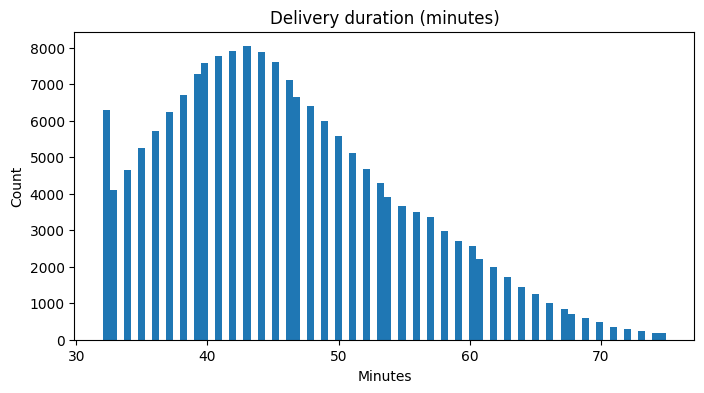

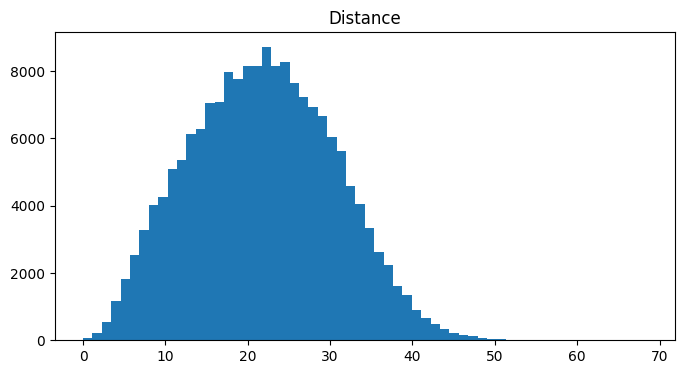

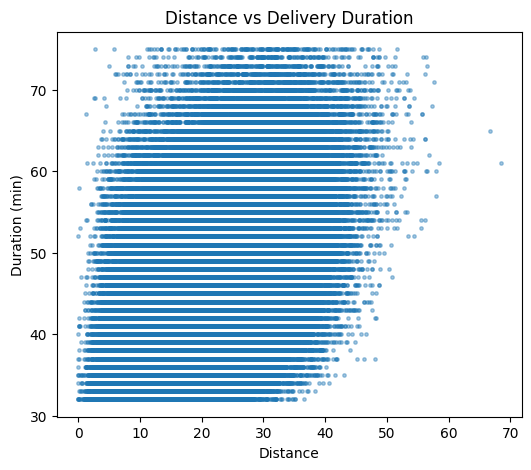

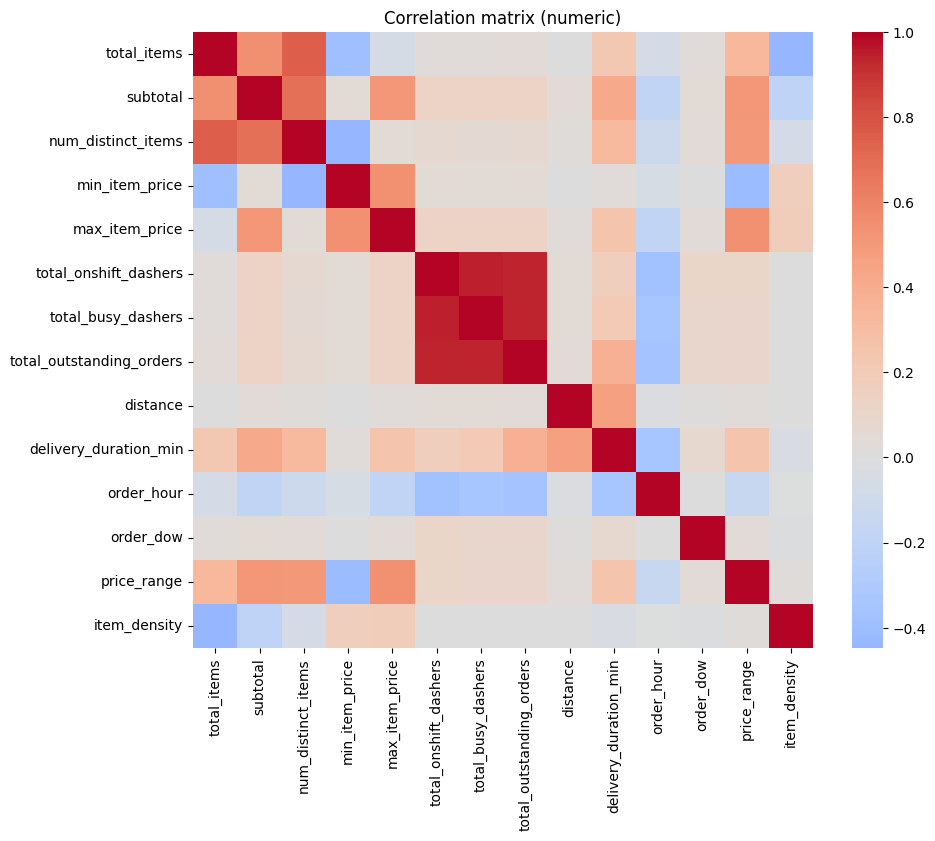

In [7]:
# Exploratory Data Analysis (run plots individually to inspect)
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of target
plt.figure(figsize=(8,4))
plt.hist(df['delivery_duration_min'], bins=80)
plt.title('Delivery duration (minutes)')
plt.xlabel('Minutes'); plt.ylabel('Count')
plt.show()

# Histogram of distance (if present)
if 'distance' in df.columns:
    plt.figure(figsize=(8,4))
    plt.hist(df['distance'], bins=60)
    plt.title('Distance')
    plt.show()

# Scatter distance vs duration
if 'distance' in df.columns:
    plt.figure(figsize=(6,5))
    plt.scatter(df['distance'], df['delivery_duration_min'], s=6, alpha=0.4)
    plt.title('Distance vs Delivery Duration')
    plt.xlabel('Distance'); plt.ylabel('Duration (min)')
    plt.show()

# Correlation heatmap (numeric)
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation matrix (numeric)')
plt.show()

In [8]:
# Select candidate features and prepare modeling dataset
candidate_features = [
    'distance', 'total_items', 'subtotal', 'num_distinct_items',
    'min_item_price', 'max_item_price', 'total_onshift_dashers',
    'total_busy_dashers', 'total_outstanding_orders', 'order_hour',
    'order_dow', 'price_range', 'item_density'
]
features = [f for f in candidate_features if f in df.columns]
target = 'delivery_duration_min'
print('Features used:', features)

df_model = df[features + [target]].dropna()
print('Rows in modeling set:', len(df_model))

# Train-test split (80/20)
X = df_model[features].copy(); y = df_model[target].copy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train rows:', len(X_train), 'Val rows:', len(X_val))

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Baseline Linear Regression
lr = LinearRegression().fit(X_train_scaled, y_train)
y_pred_val = lr.predict(X_val_scaled)

def metrics(y_true, y_pred):
    return {'MAE': mean_absolute_error(y_true, y_pred),
            'RMSE': mean_squared_error(y_true, y_pred, squared=False),
            'R2': r2_score(y_true, y_pred)}

print('Baseline metrics:', metrics(y_val, y_pred_val))

Features used: ['distance', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'order_hour', 'order_dow', 'price_range', 'item_density']
Rows in modeling set: 174907
Train rows: 139925 Val rows: 34982


Baseline metrics: {'MAE': 2.4383557683939734, 'RMSE': 3.316934953653158, 'R2': 0.8645052304458518}


In [9]:
# Feature selection: RFE on a sample (faster) and SelectKBest
sample_size = min(40000, len(X_train))
print('RFE sample size:', sample_size)
rfe_sample = X_train.sample(sample_size, random_state=42)
rfe_sample_y = y_train.loc[rfe_sample.index]

# Fit RFE (choose up to 8 features)
n_select = min(8, X_train.shape[1])
rfe = RFE(estimator=LinearRegression(), n_features_to_select=n_select, step=1)
rfe.fit(rfe_sample, rfe_sample_y)
rfe_selected = [f for f,s in zip(features, rfe.get_support()) if s]
print('RFE selected (sample-based):', rfe_selected)

# SelectKBest as alternative
k = min(8, X_train.shape[1])
skb = SelectKBest(score_func=f_regression, k=k).fit(X_train, y_train)
skb_selected = [f for f,s in zip(features, skb.get_support()) if s]
print('SelectKBest selected:', skb_selected)

# Evaluate model using skb_selected
sel = skb_selected
scaler_sel = StandardScaler()
X_train_sel = scaler_sel.fit_transform(X_train[sel])
X_val_sel = scaler_sel.transform(X_val[sel])
lr_sel = LinearRegression().fit(X_train_sel, y_train)
print('Metrics (SelectKBest-LR):', metrics(y_val, lr_sel.predict(X_val_sel)))

RFE sample size: 40000


RFE selected (sample-based): ['distance', 'total_items', 'num_distinct_items', 'total_onshift_dashers', 'total_outstanding_orders', 'order_hour', 'order_dow', 'item_density']
SelectKBest selected: ['distance', 'total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_outstanding_orders', 'order_hour', 'price_range']


Metrics (SelectKBest-LR): {'MAE': 4.979893542669783, 'RMSE': 6.283737615110383, 'R2': 0.5137219064967002}


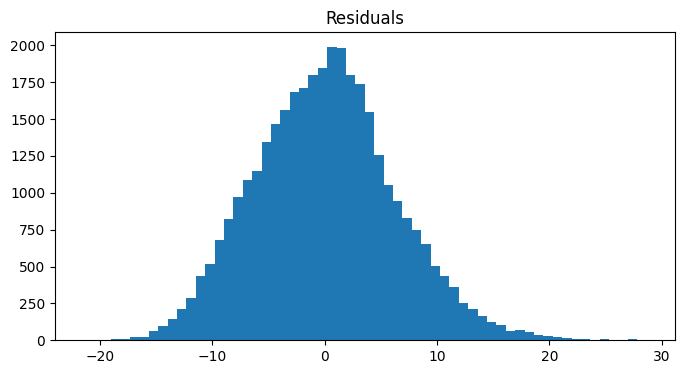

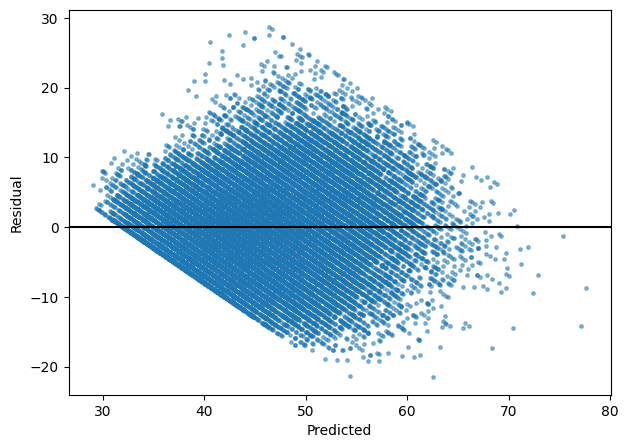

,feature,coef,abs_coef
0,distance,3.943172,3.943172
1,total_outstanding_orders,2.299705,2.299705
2,subtotal,2.096643,2.096643
3,order_hour,-1.592706,1.592706
4,num_distinct_items,1.068133,1.068133
5,max_item_price,0.548765,0.548765
6,price_range,-0.184422,0.184422
7,total_items,-0.065158,0.065158


In [10]:
# Residual analysis and coefficients for selected model
y_pred_sel = lr_sel.predict(X_val_sel)
residuals = y_val - y_pred_sel

# Residual histogram
plt.figure(figsize=(8,4)); plt.hist(residuals, bins=60); plt.title('Residuals'); plt.show()

# Residuals vs predicted
plt.figure(figsize=(7,5)); plt.scatter(y_pred_sel, residuals, s=6, alpha=0.5); plt.axhline(0, color='k'); plt.xlabel('Predicted'); plt.ylabel('Residual'); plt.show()

# Coefficients table
coefs = pd.DataFrame({'feature': sel, 'coef': lr_sel.coef_})
coefs['abs_coef'] = coefs['coef'].abs()
coefs = coefs.sort_values('abs_coef', ascending=False)
coefs.reset_index(drop=True, inplace=True)
coefs

In [11]:
# Optional: save selected features list and metrics to CSV for the report
out = {
    'selected_features': sel,
    'validation_metrics': metrics(y_val, lr_sel.predict(X_val_sel))
}
import json
with open('/mnt/data/model_summary.json','w') as f:
    json.dump(out, f, indent=2)
print('Saved model_summary.json to /mnt/data')

Saved model_summary.json to /mnt/data


## Subjective Questions (Answers)

**Q1. How did you handle missing values and why?**  
A1. Numeric missing values were imputed with median values to reduce sensitivity to outliers; categorical missing values were filled with 'missing' so the information about missingness is preserved. This approach prevents dropping many rows and keeps the dataset representative.

**Q2. How did you handle outliers?**  
A2. Extreme outliers in the target were removed by trimming values below the 0.1% and above the 99.5% quantiles, which removes likely erroneous entries and rare extreme cases that could disproportionately affect a linear model.

**Q3. Why use RFE and SelectKBest?**  
A3. RFE provides model-based recursive elimination and helps find a subset of features that perform well jointly, while SelectKBest is a fast univariate filter to quickly reduce dimensionality. Using both offers a balance of speed and joint-feature evaluation.

**Q4. Recommendations for Porter operations**  
A4. 1) Allocate more dashers during peak hours; 2) Monitor outstanding orders and balance assignments; 3) Use model-predicted ETAs to set customer expectations; 4) Add traffic and weather data to improve model accuracy.
